# init

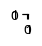

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

# init

In [86]:
DIR = '../output/230427_FINAL_ANALYSIS_ALL/'

## reloading datasets

In [2]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
# merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')
nepdb = pd.read_csv('../data/mutant/230124_nepdb_filtered_scored.csv')
nepdb.head()

,Peptide,wild_type,HLA,agg_label,mut_len,wt_len,seq_id,Pos_mut,Peptide_mut,core_mut,...,core_blsm_mut_score,aliphatic_index,boman,hydrophobicity,isoelectric_point,VHSE1,VHSE3,VHSE7,VHSE8,trueHLA_EL_rank
0,AFGSAHLFR,AFGSAHLYR,HLA-A3101,1,9,9,seq_1,0,AFGSAHLFR,AFGSAHLFR,...,3,65.555556,0.837778,0.455556,10.551759,0.214444,-0.278889,0.193333,-0.192222,0.2470
1,AIANRIKFK,AIANRIKSK,HLA-A1101,0,9,9,seq_4,0,AIANRIKFK,AIANRIKFK,...,-2,108.888889,1.802222,-0.044444,11.823055,-0.048889,0.125556,0.484444,-0.125556,0.1380
2,AICKPLHYV,AICKPLHYM,HLA-A0201,0,9,9,seq_5,0,AICKPLHYV,AICKPLHYV,...,1,130.000000,-0.735556,0.755556,8.530526,0.327778,0.046667,-0.017778,0.263333,0.3610
3,AIPAMVVPNV,AIPAMVVPNA,HLA-A0201,0,10,10,seq_6,0,AIPAMVVPNV,AIPAVVPNV,...,0,146.000000,-1.637000,1.590000,6.100000,0.431000,-0.385000,-0.067000,0.446000,2.2606
4,ALEVLQSIPY,APEVLQSIPY,HLA-A0101,0,10,10,seq_7,0,ALEVLQSIPY,ALEVLQSIY,...,-3,156.000000,-0.472000,0.740000,3.849983,0.292000,-0.062000,-0.096000,0.088000,0.6230


In [3]:
cedar_expr = pd.read_csv('../data/pepx/230125_cedar_related_pepx_fold.csv')
prime_expr = pd.read_csv('../data/pepx/230125_prime_related_pepx.csv')
ibel_expr = pd.read_csv('../data/pepx/230125_ibel_normal_pepx.csv')
nepdb_expr = pd.read_csv('../data/pepx/230125_nepdb_normal_pepx.csv')

In [4]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230308_cedar_aligned_icore.csv')
prime_aligned = pd.read_csv('../data/aligned_icore/230308_prime_aligned_icore.csv')
ibel_aligned = pd.read_csv('../data/aligned_icore/230308_ibel_aligned_icore.csv')
nepdb_aligned = pd.read_csv('../data/aligned_icore/230308_nepdb_aligned_icore.csv')

In [5]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230418_cedar_aligned_pepx.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230418_prime_aligned_pepx.csv')
ibel_aligned_expr = pd.read_csv('../data/pepx/230125_ibel_aligned_pepx.csv')
nepdb_aligned_expr = pd.read_csv('../data/pepx/230418_nepdb_aligned_pepx.csv')

In [6]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

# Masking threshold detour

In [28]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': True,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'seq_col': 'icore_mut',
                   'rank_col': 'EL_rank_mut',
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                   'None': (False, 'None', None, False),
                   'Mask': (False, 'Mask', ics_shannon, True),
                   'Shannon': (False, 'Shannon', ics_shannon, False),
                   'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True)}

invert, ic_name, ics_dict, mask = conditions_list['Mask']
# megaloops for encoding-weighting

encoding_kwargs['encoding'] = 'onehot'
encoding_kwargs['blosum_matrix'] = None
# Doing only Inverted Shannon, Mask, None

encoding_kwargs['invert'] = invert
encoding_kwargs['mask'] = mask

xd=[]
for threshold in np.linspace(0.14,0.3, 30):
    # Using the same model and hyperparameters
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    encoding_kwargs['threshold']=threshold
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    for evalset, evalname in zip([cedar_aligned, prime_aligned],
                                 ['CEDAR', 'PRIME']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']),
                                                   trained_models, ics_dict,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=True, n_jobs=8)        
        pcol = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pcol], preds['agg_label'],10000,n_jobs=8, auc01=False, add_roc=False, reduced=True)
        bootstrapped_df['threshold'] = threshold
        bootstrapped_df['evalset']=evalname
        xd.append(bootstrapped_df)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.15

In [54]:
def get_expanded_input(row):
    input_col = row['core_mut'] if row['len_icore_mut']==8 else row['icore_mut']
    return input_col
cedar_aligned['expanded_input'] = cedar_aligned.apply(get_expanded_input, axis=1)
prime_aligned['expanded_input'] = prime_aligned.apply(get_expanded_input, axis=1)


In [55]:
from sklearn.ensemble import RandomForestClassifier
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
# DEFINING KWARGS
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': True,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'seq_col': 'expanded_input',
                   'rank_col': 'EL_rank_mut',
                   'hla_col': 'HLA',
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}

conditions_list = {'Inverted-Shannon': (True, 'Inverted-Shannon', ics_shannon, False),
                   'None': (False, 'None', None, False),
                   'Mask': (False, 'Mask', ics_shannon, True),
                   'Shannon': (False, 'Shannon', ics_shannon, False),
                   'Inverted-Mask': (True, 'Inverted-Mask', ics_shannon, True)}

invert, ic_name, ics_dict, mask = conditions_list['Mask']
# megaloops for encoding-weighting

encoding_kwargs['encoding'] = 'onehot'
encoding_kwargs['blosum_matrix'] = None
# Doing only Inverted Shannon, Mask, None

encoding_kwargs['invert'] = invert
encoding_kwargs['mask'] = mask

xd2=[]
for threshold in np.linspace(0.14,0.3, 30):
    # Using the same model and hyperparameters
    model = RandomForestClassifier(n_jobs=1, min_samples_leaf=7, n_estimators=300,
                                   max_depth=8, ccp_alpha=9.945e-6)
    # Training model and getting feature importances
    print('Training')
    encoding_kwargs['threshold']=threshold
    trained_models, train_metrics, _ = nested_kcv_train_sklearn(cedar_aligned, model,
                                                                ics_dict=ics_dict,
                                                                encoding_kwargs=encoding_kwargs,
                                                                n_jobs=8)
    for evalset, evalname in zip([cedar_aligned, prime_aligned],
                                 ['CEDAR', 'PRIME']):
        # FULLY FILTERED + Mean_pred
        if not evalset.equals(cedar_aligned):
            evalset = evalset.query('Peptide not in @cedar_aligned.Peptide.values')
        _, preds = evaluate_trained_models_sklearn(evalset.drop_duplicates(subset=['Peptide', 'HLA', 'agg_label']),
                                                   trained_models, ics_dict,
                                                   cedar_aligned,
                                                   encoding_kwargs, concatenated=False,
                                                   only_concat=True, n_jobs=8)        
        pcol = 'pred' if 'pred' in preds.columns else 'mean_pred'
        bootstrapped_df = bootstrap_eval(preds[pcol], preds['agg_label'],10000,n_jobs=8, auc01=False, add_roc=False, reduced=True)
        bootstrapped_df['threshold'] = threshold
        bootstrapped_df['evalset']=evalname
        xd2.append(bootstrapped_df)

Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.14551724137931035


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1510344827586207


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.15655172413793106


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.1620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.16758620689655174


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17310344827586208


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.17862068965517242


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18413793103448278


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.18965517241379312


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.19517241379310346


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2006896551724138


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.20620689655172414


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2117241379310345


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.21724137931034482


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22275862068965518


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.22827586206896552


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23379310344827586


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.23931034482758623


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.24482758620689654


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2503448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2558620689655172


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2613793103448276


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.26689655172413795


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27241379310344827


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.27793103448275863


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.283448275862069


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2889655172413793


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.2944827586206896


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves
Training


Train:Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

0.3


Inner Folds:   0%|          | 0/9 [00:00<?, ?it/s]

Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


Eval Folds:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

Making results DF and curves


In [56]:
z = pd.concat(xd).assign(input_type='icore')
y = pd.concat(xd2).assign(input_type='expanded8mers')


In [386]:
for h in ics_shannon[9].keys():
    print('\n',h, '\n', [round(x,4) for x in ics_shannon[9][h][0.25]])


 HLA-A0101 
 [0.0448, 0.3621, 0.209, 0.0588, 0.0406, 0.0453, 0.0516, 0.0584, 0.8584]

 HLA-A0201 
 [0.1177, 0.6666, 0.0787, 0.1619, 0.042, 0.1222, 0.0667, 0.0758, 0.5667]

 HLA-A0202 
 [0.1107, 0.6749, 0.0607, 0.1663, 0.0499, 0.1034, 0.0567, 0.0816, 0.5931]

 HLA-A0203 
 [0.1205, 0.6533, 0.0629, 0.154, 0.0446, 0.1388, 0.0619, 0.0851, 0.5473]

 HLA-A0205 
 [0.1177, 0.4183, 0.0784, 0.2199, 0.0526, 0.1366, 0.0625, 0.0938, 0.5813]

 HLA-A0206 
 [0.1219, 0.4158, 0.0961, 0.2046, 0.0453, 0.1528, 0.0716, 0.0874, 0.5567]

 HLA-A0210 
 [0.1153, 0.4406, 0.0971, 0.1912, 0.0457, 0.1423, 0.0707, 0.0841, 0.5704]

 HLA-A0211 
 [0.1186, 0.6794, 0.0698, 0.1394, 0.0427, 0.1175, 0.0598, 0.0737, 0.5808]

 HLA-A0224 
 [0.1177, 0.6666, 0.0787, 0.1619, 0.042, 0.1222, 0.0667, 0.0758, 0.5667]

 HLA-A0301 
 [0.2145, 0.3914, 0.0682, 0.069, 0.0544, 0.0727, 0.0946, 0.0628, 0.8189]

 HLA-A0302 
 [0.1959, 0.393, 0.0628, 0.0716, 0.0546, 0.0665, 0.0788, 0.0648, 0.8311]

 HLA-A1101 
 [0.1842, 0.3793, 0.0737, 0.074, 0.0

Text(0.5, 1.0, 'Using the Expanded 8 mers as input (taking CORES for 8mers, or ICORES for the rest)')

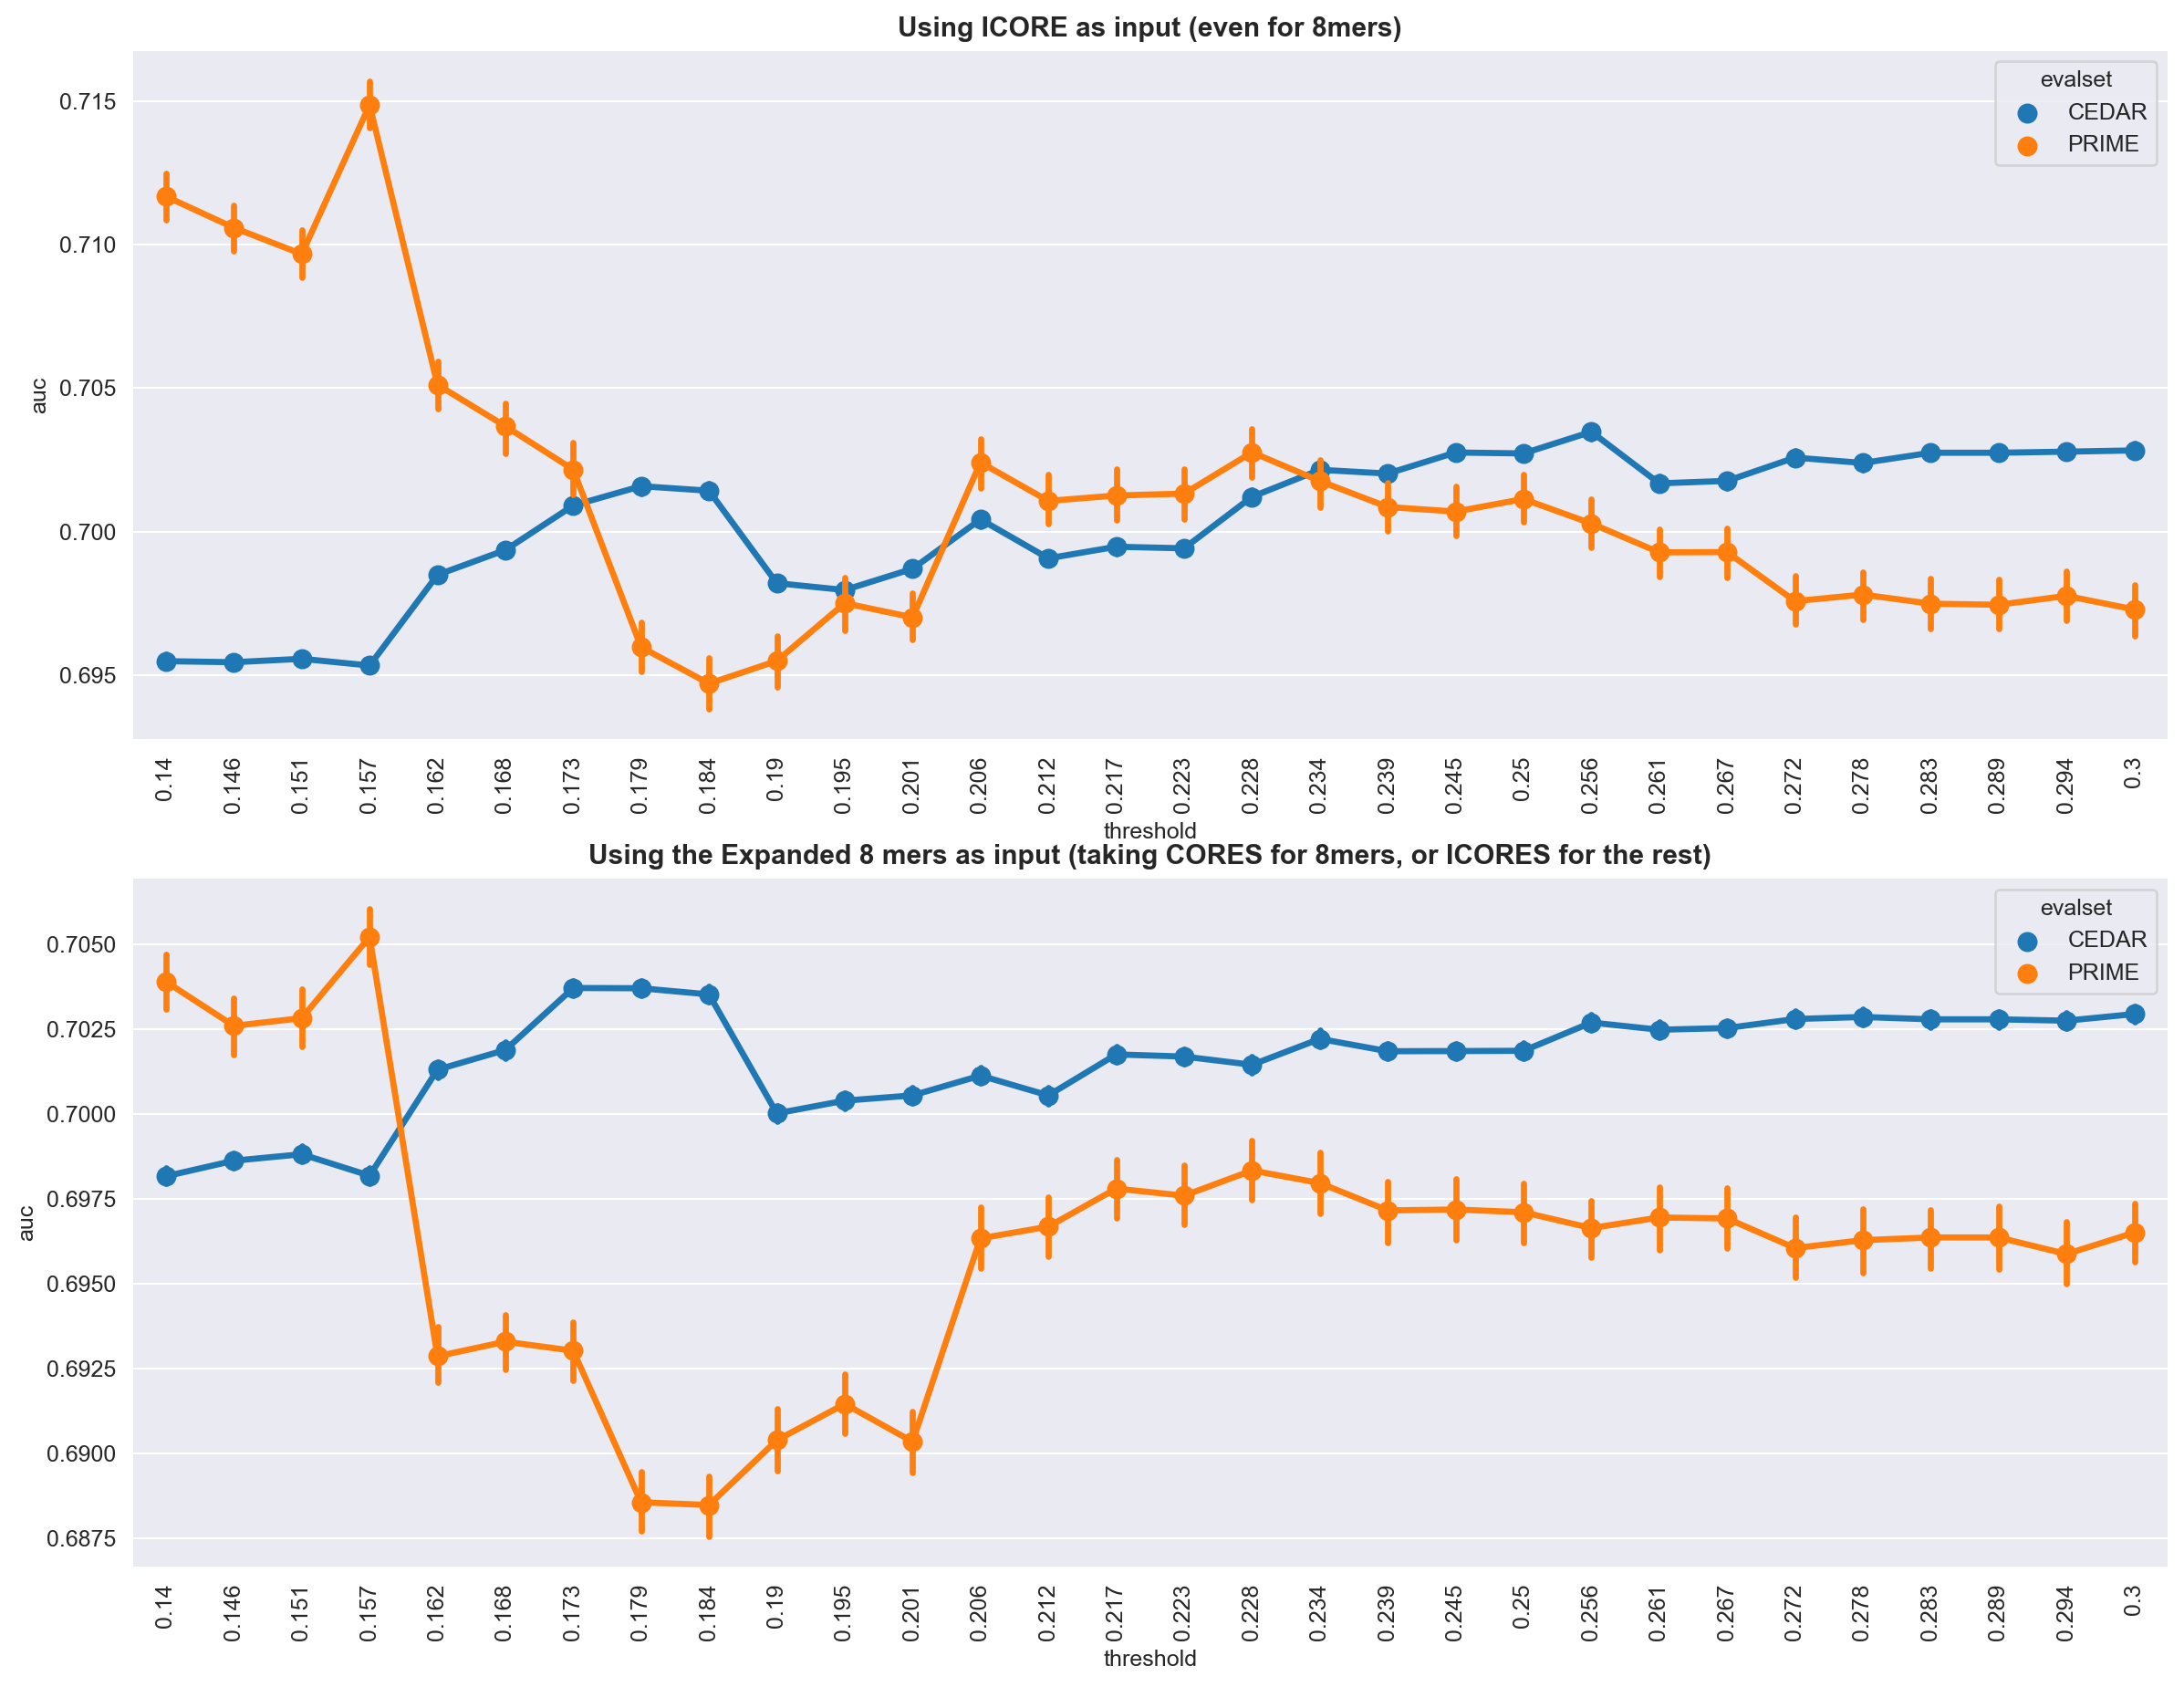

0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.14551724137931035
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1510344827586207
0.1

In [59]:
f,a = plt.subplots(2,1, figsize=(16,12))

a = a.ravel()
sns.pointplot(data=z, hue = 'evalset', x='threshold', y='auc', ax=a[0])
a[0].set_xticklabels([round(float(str(x)[str(x).find('\'')+1:str(x).rfind('\'')]),3)\
                   for x in a[0].get_xticklabels()], rotation=90)


sns.pointplot(data=y, hue = 'evalset', x='threshold', y='auc', ax=a[1])
a[1].set_xticklabels([round(float(str(x)[str(x).find('\'')+1:str(x).rfind('\'')]),3)\
                   for x in a[1].get_xticklabels()], rotation=90)

a[0].set_title('Using ICORE as input (even for 8mers)', fontweight='semibold')


a[1].set_title('Using the Expanded 8 mers as input (taking CORES for 8mers, or ICORES for the rest)', fontweight='semibold')

MultiIndex([('a',),
            ('b',)],
           )

In [67]:
pd.DataFrame([[0,1,2])

,0,1,2
0,0,1,2


In [73]:
x = pd.DataFrame([[0, 2, 3]], columns=['a1', 'b2', 'c3'], index=pd.MultiIndex.from_arrays(np.array([ ['a','b']])))
y = pd.DataFrame([[10, 2, 3]], columns=['a', 'z', '13'], index=pd.MultiIndex.from_arrays(np.array([ ['a','b']])))
pd.merge(x,y, left_index=True, right_index=True)

,a1,b2,c3,a,z,13
a,0,2,3,10,2,3
b,0,2,3,10,2,3


In [78]:
np.unique([x[5:] for x in list(filter(lambda x: x.endswith('csv'), os.listdir('../output/230314_bulgeOut_aligned/bootstrapping/')))])

array(['_bootstrapped_df_onehot_Inverted-KL_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_Inverted-Mask_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_Inverted-Shannon_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_KL_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_Mask_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_None_bulgeOutTrue_rank_only.csv',
       '_bootstrapped_df_onehot_Shannon_bulgeOutTrue_rank_only.csv'],
      dtype='<U67')

# Input analysis (Fig 3,4)

In [79]:
input_df = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/input_df_comparison.csv')
bdfs2 = pd.read_csv('../output/230427_FINAL_ANALYSIS_ALL/input_df_comparison_prime_threshold_03.csv')

## results figs

0.0
0.0


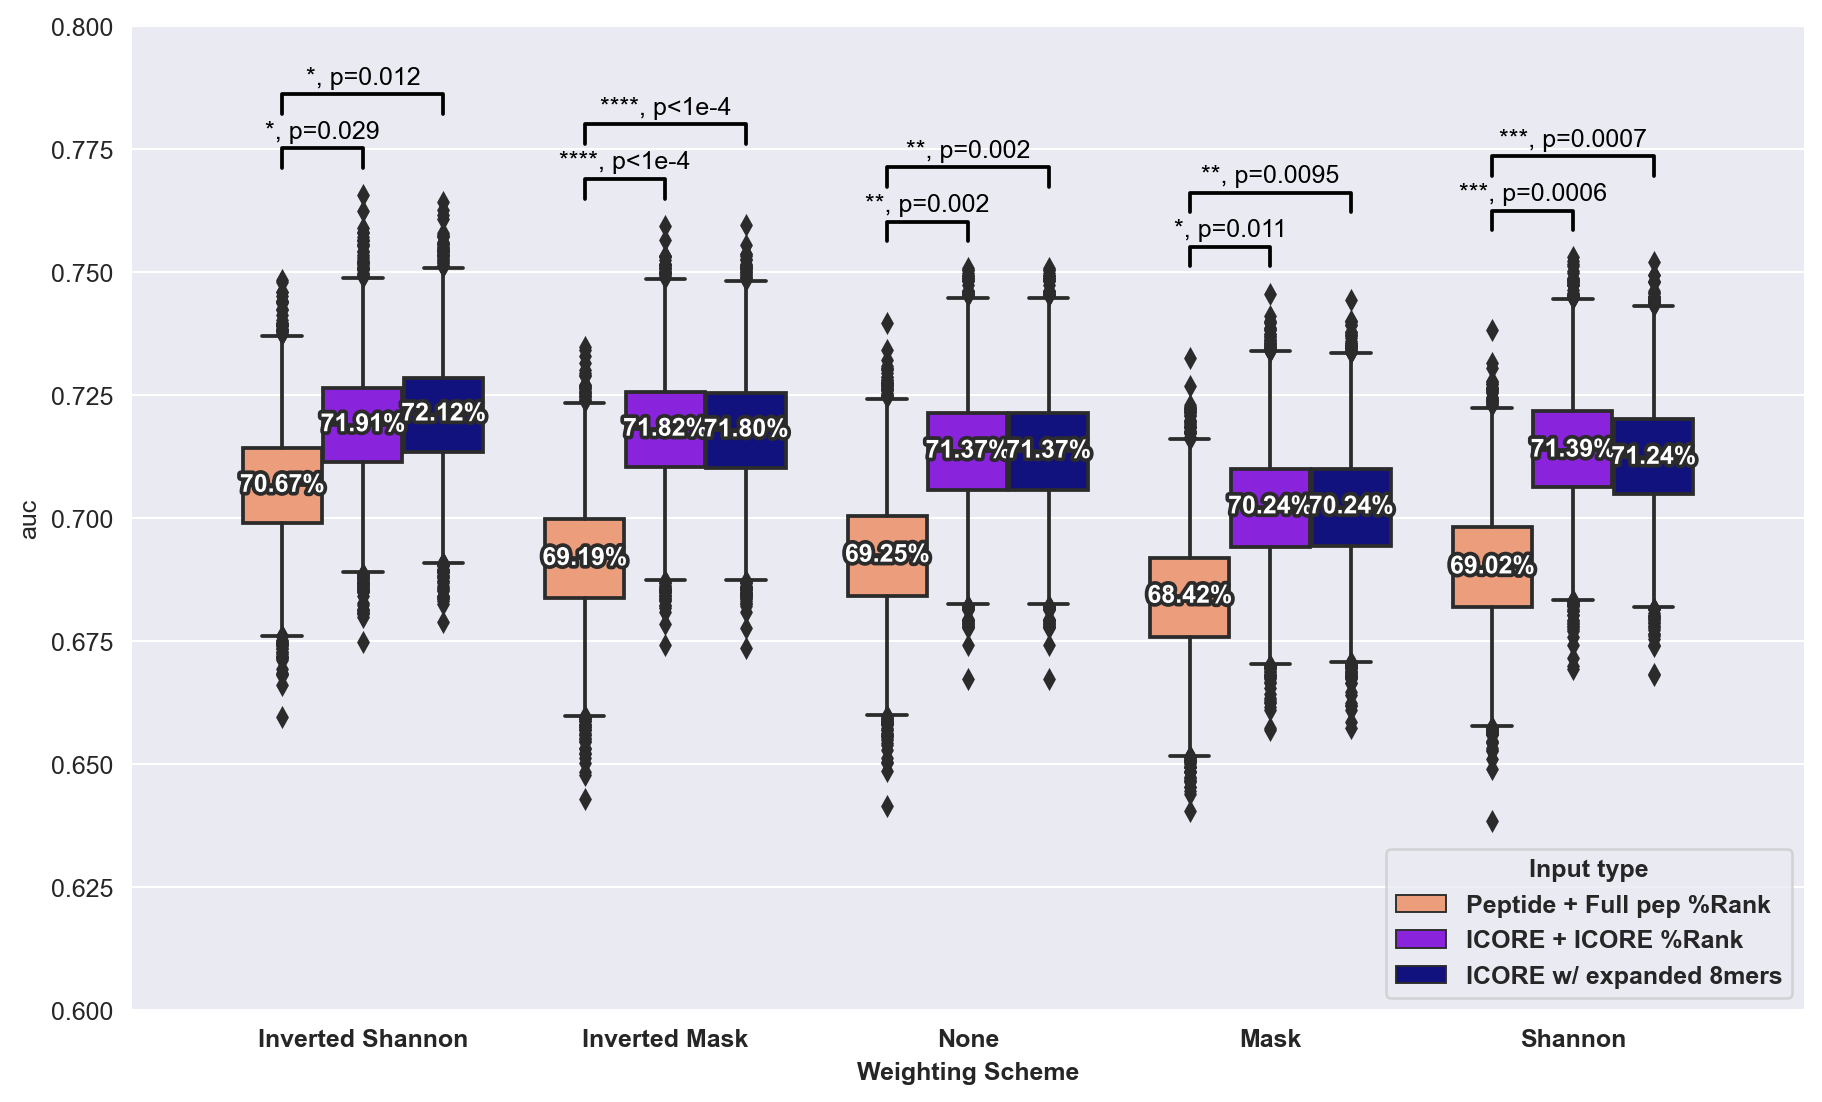

In [80]:
from src.bootstrap import get_pval_wrapper
f,a = plt.subplots(1,1, figsize=(12,7.1))
weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
sns.boxplot(data=input_df.query('evalset=="CEDAR"').replace({'Peptide':'Peptide + Full pep %Rank',
                                                             'icore_mut':'ICORE + ICORE %Rank',
                                                             'expanded_input':'ICORE w/ expanded 8mers'}), 
            hue= 'input_type', y='auc', x = 'weight', order=weight_order, 
            palette=get_palette('gnuplot2_r', n_colors=3))
# a.set_title('Inputs comparison, bootstrapped crossvalidation AUCs for CEDAR', fontweight = 'semibold', fontsize=14)
add_median_labels(a, fmt='.2%')

# pvals
for weight in weight_order:
    x0 = weight_order.index(weight)
    x1,x2,x3 = x0-(0.8/3), x0, x0+(0.8/3)
    
    aucs_pep = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="Peptide"').auc.values#.sort_values('seed').auc.values
    aucs_icore = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="icore_mut"').auc.values#.sort_values('seed').auc.values
    aucs_exp = input_df.query('evalset=="CEDAR" and weight==@weight and input_type=="expanded_input"').auc.values#.sort_values('seed').auc.values
    h = 0.0055
    y0 = max(aucs_icore)+h
    y1 = max(max(aucs_icore), max(aucs_exp)) + 3*h
    
    # Pep vs ICORE
    pval, sig = get_pval_wrapper(input_df.query("evalset=='CEDAR' and weight==@weight and input_type=='icore_mut'"), 
                                 input_df.query("evalset=='CEDAR' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x2, y = y0, h=0.005)
    
    # Pep vs Expanded
    pval, sig = get_pval_wrapper(input_df.query("evalset=='CEDAR' and weight==@weight and input_type=='expanded_input'"), 
                                 input_df.query("evalset=='CEDAR' and weight==@weight and input_type == 'Peptide'"),
                                 'auc')
    plot_pval(a, pval, sig, x1, x3, y = y1, h=0.005)
a.set_xticklabels(a.get_xticklabels(), fontweight='semibold')
a.set_xlabel('Weighting Scheme', fontweight='semibold')
a.set_ylim([0.6,0.8])
a.legend(loc='lower right', title='Input type', prop=dict(weight='semibold'), title_fontproperties=dict(weight='semibold'))
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_input_comparisons_pvals.png', dpi=200, bbox_inches='tight')

In [91]:
len(cedar_aligned_expr.HLA.unique())

63

In [92]:
len(prime_aligned_expr.HLA.unique())

48

0.1382 ns
0.07799999999999996 ns
0.26070000000000004 ns
0.31920000000000004 ns
0.03359999999999996 *
0.06120000000000003 ns
0.33109999999999995 ns
0.3823 ns


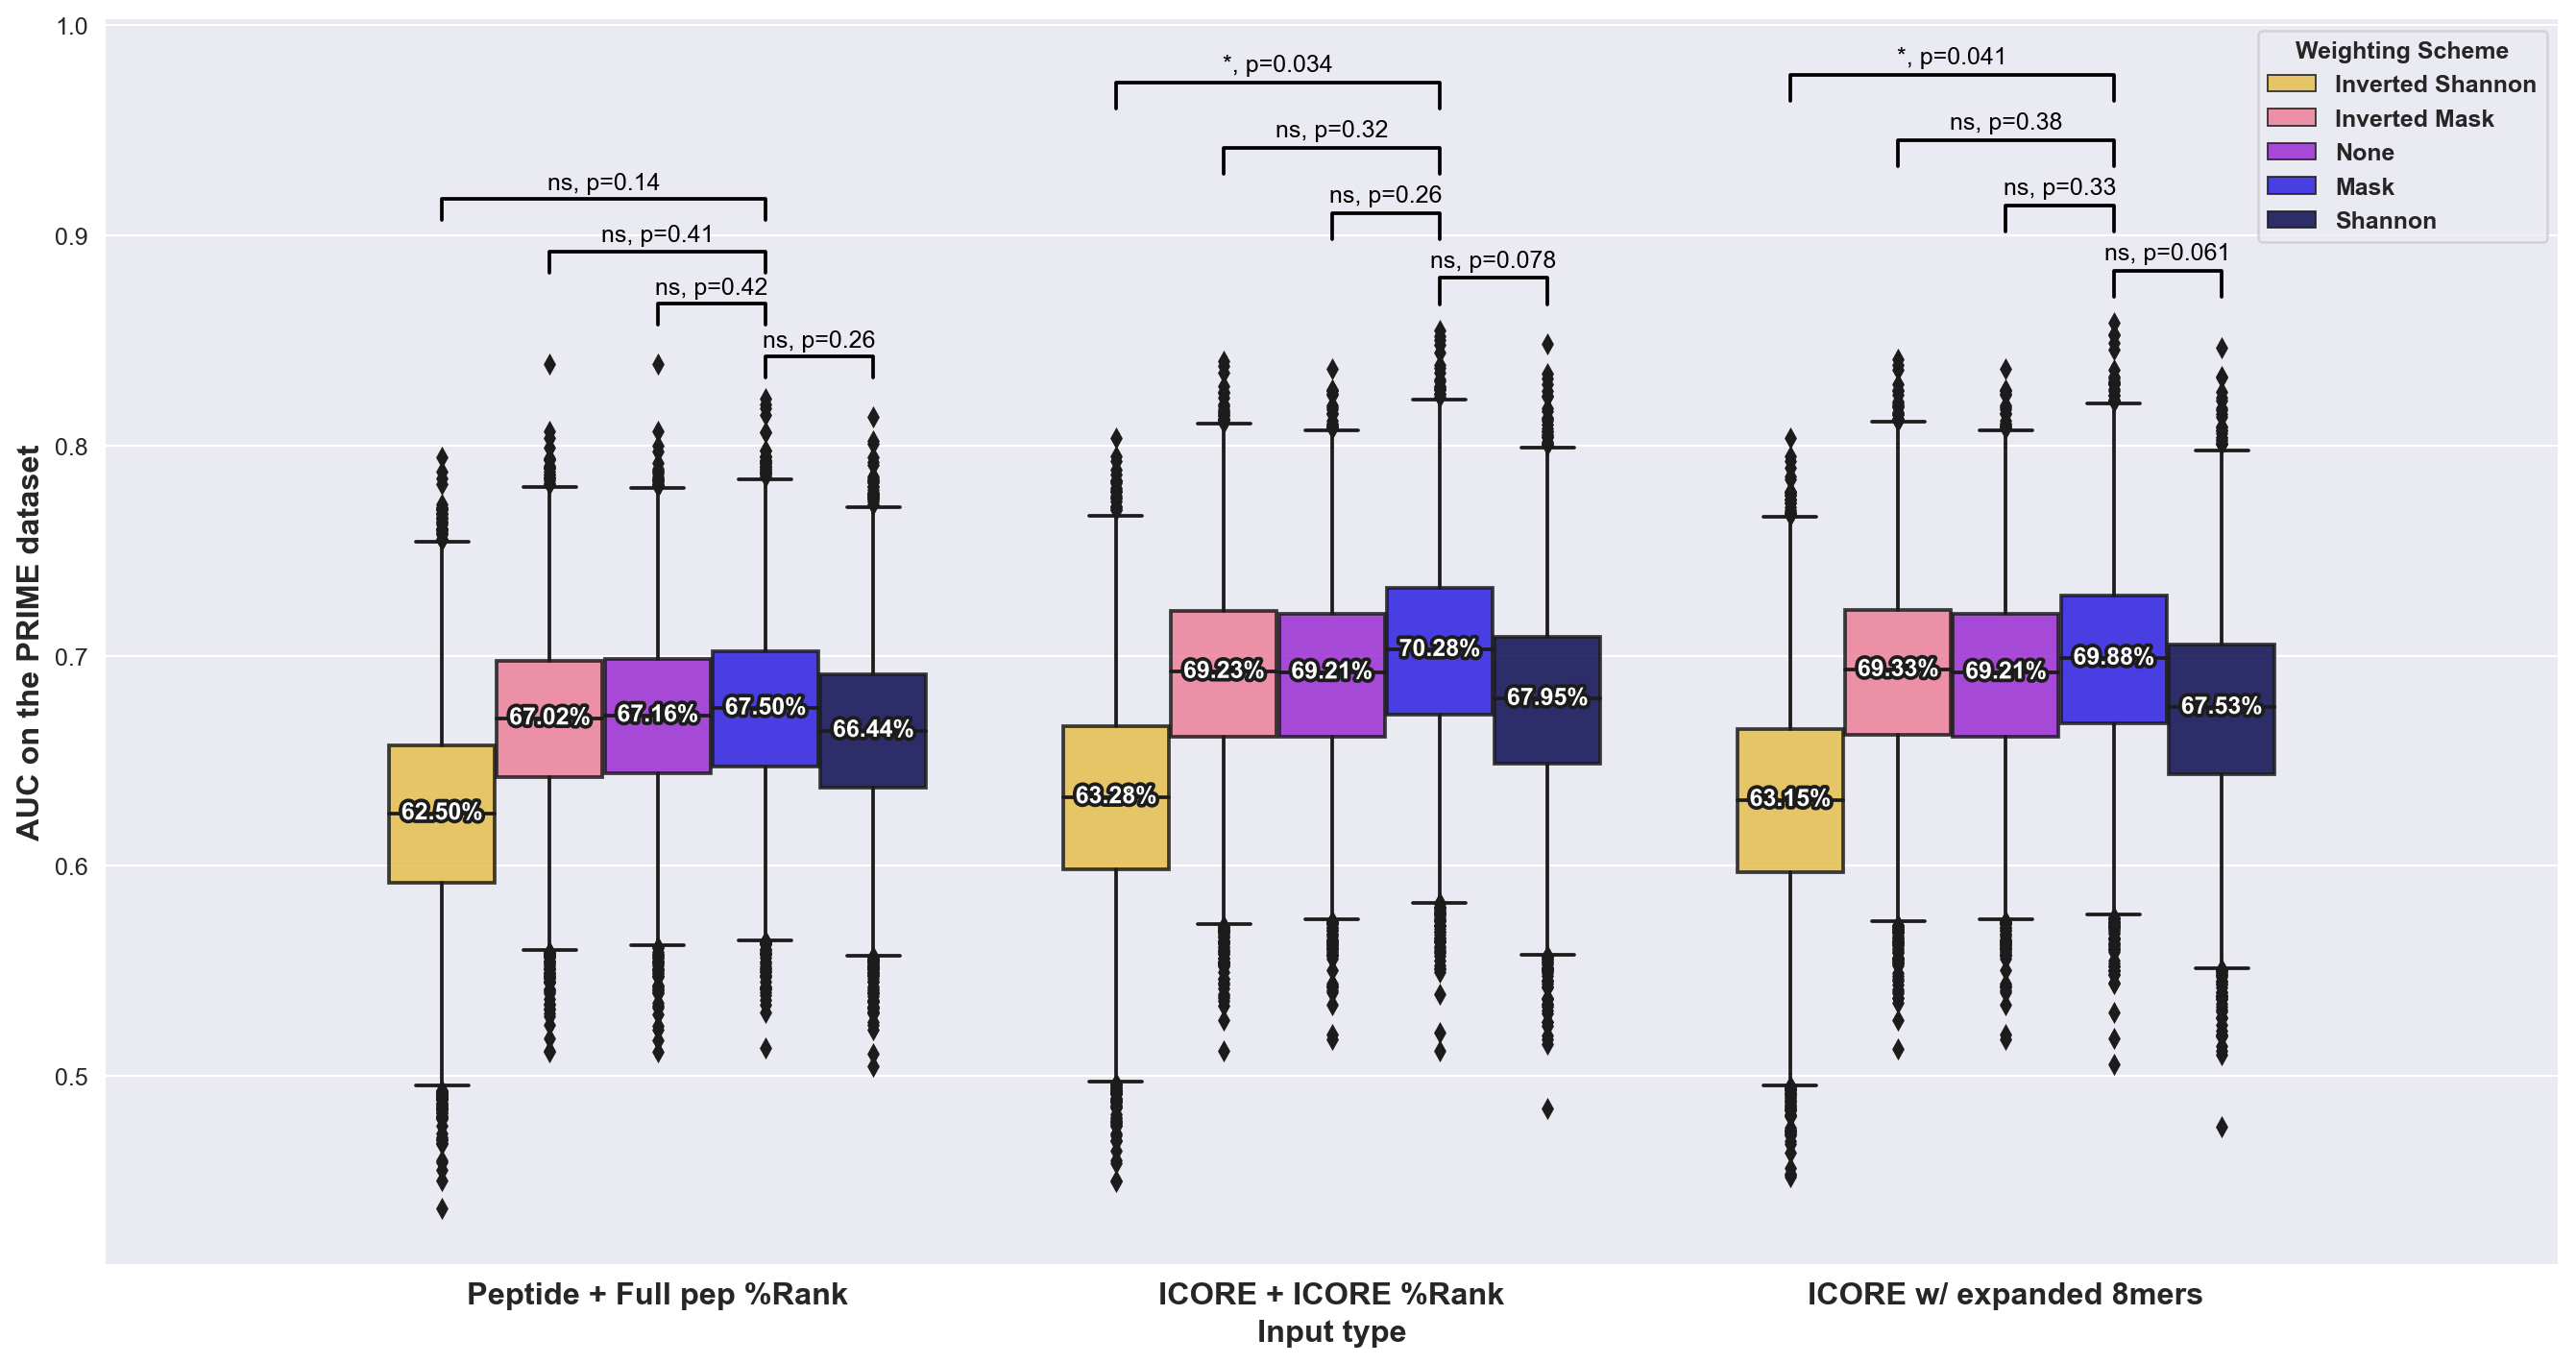

In [82]:
# Remake fig4 for PRIME

# Redo the figure here for prime only as requested
f, axis = plt.subplots(1,1, figsize=(15,8), sharex=True)
weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
weight_color_order = {k:v for k,v in zip(weight_order, get_palette('gnuplot2_r', n_colors=len(weight_order)))}
# for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):

def get_input(row):
    if row['input_type']=='Peptide':return 'Peptide + Full pep %Rank'
    if row['input_type']=='icore_mut':return 'ICORE + ICORE %Rank'
    if row['input_type']=='expanded_input':return 'ICORE w/ expanded 8mers'

tmp = input_df.query('evalset=="PRIME"')

tmp['type']=tmp.apply(get_input,axis=1)
sns.boxplot(data= tmp, x='type', hue = 'weight', y = 'auc',
            hue_order = weight_order, palette = weight_color_order, ax=axis)
add_median_labels(axis, '.2%')

# axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
axis.set_ylabel('AUC on the PRIME dataset', fontweight='semibold', fontsize=13)
plt.setp(axis.patches, alpha=0.85)

# X0 (CEDAR) pvals
dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 0
xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.01, 0.0125
aucs_mask = tmp.query('evalset=="PRIME"  and type.str.contains("Peptide") and weight=="Mask"')

for i, comp in enumerate(reversed(list(filter(lambda x: x!='Mask', weight_order)))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("Peptide") and weight==@comp')
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp, 'auc')
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0

# X1 (PRIME) pvals
dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 1
xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.0125, 0.0155
aucs_mask = tmp.query('evalset=="PRIME" and type.str.contains("ICORE") and not type.str.contains("exp") and weight=="Mask"')
for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("ICORE") and not type.str.contains("exp") and weight==@comp')
    print(pval, sig)
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0
    
    
# X1 (PRIME) pvals
dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
x0 = 2
xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
x1 = xs[weight_order.index('Mask')]
h, h0 = 0.0125, 0.0155
aucs_mask = tmp.query('evalset=="PRIME" and type.str.contains("exp") and weight=="Mask"')
for comp in reversed(list(filter(lambda x: x!='Mask', weight_order))):
    x2 = xs[weight_order.index(comp)]
    aucs_comp = tmp.query('evalset=="PRIME" and type.str.contains("exp") and weight==@comp')
    print(pval, sig)
    pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
    plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
    # x1+=dx
    h+=2*h0
        
# axis.set_ylim([.5, .925])
axis.legend(prop={'weight':'semibold'}, title='Weighting Scheme', title_fontproperties={'weight':'semibold'})
# a.set_xlabel('')
axis.set_xlabel('Input type', fontweight='semibold', fontsize=13)
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_PRIME_ONLY_weights_comparison_newpal_pvals.png',
          bbox_inches='tight', dpi=200)

0.02429999999999999 *
0.29469999999999996 ns
0.05410000000000004 ns
0.263 ns
0.45520000000000005 ns
0.17279999999999995 ns
0.03590000000000004 *
0.18279999999999996 ns
0.1382 ns
0.07799999999999996 ns
0.26070000000000004 ns
0.31920000000000004 ns
0.03359999999999996 *
0.06120000000000003 ns
0.33109999999999995 ns
0.3823 ns


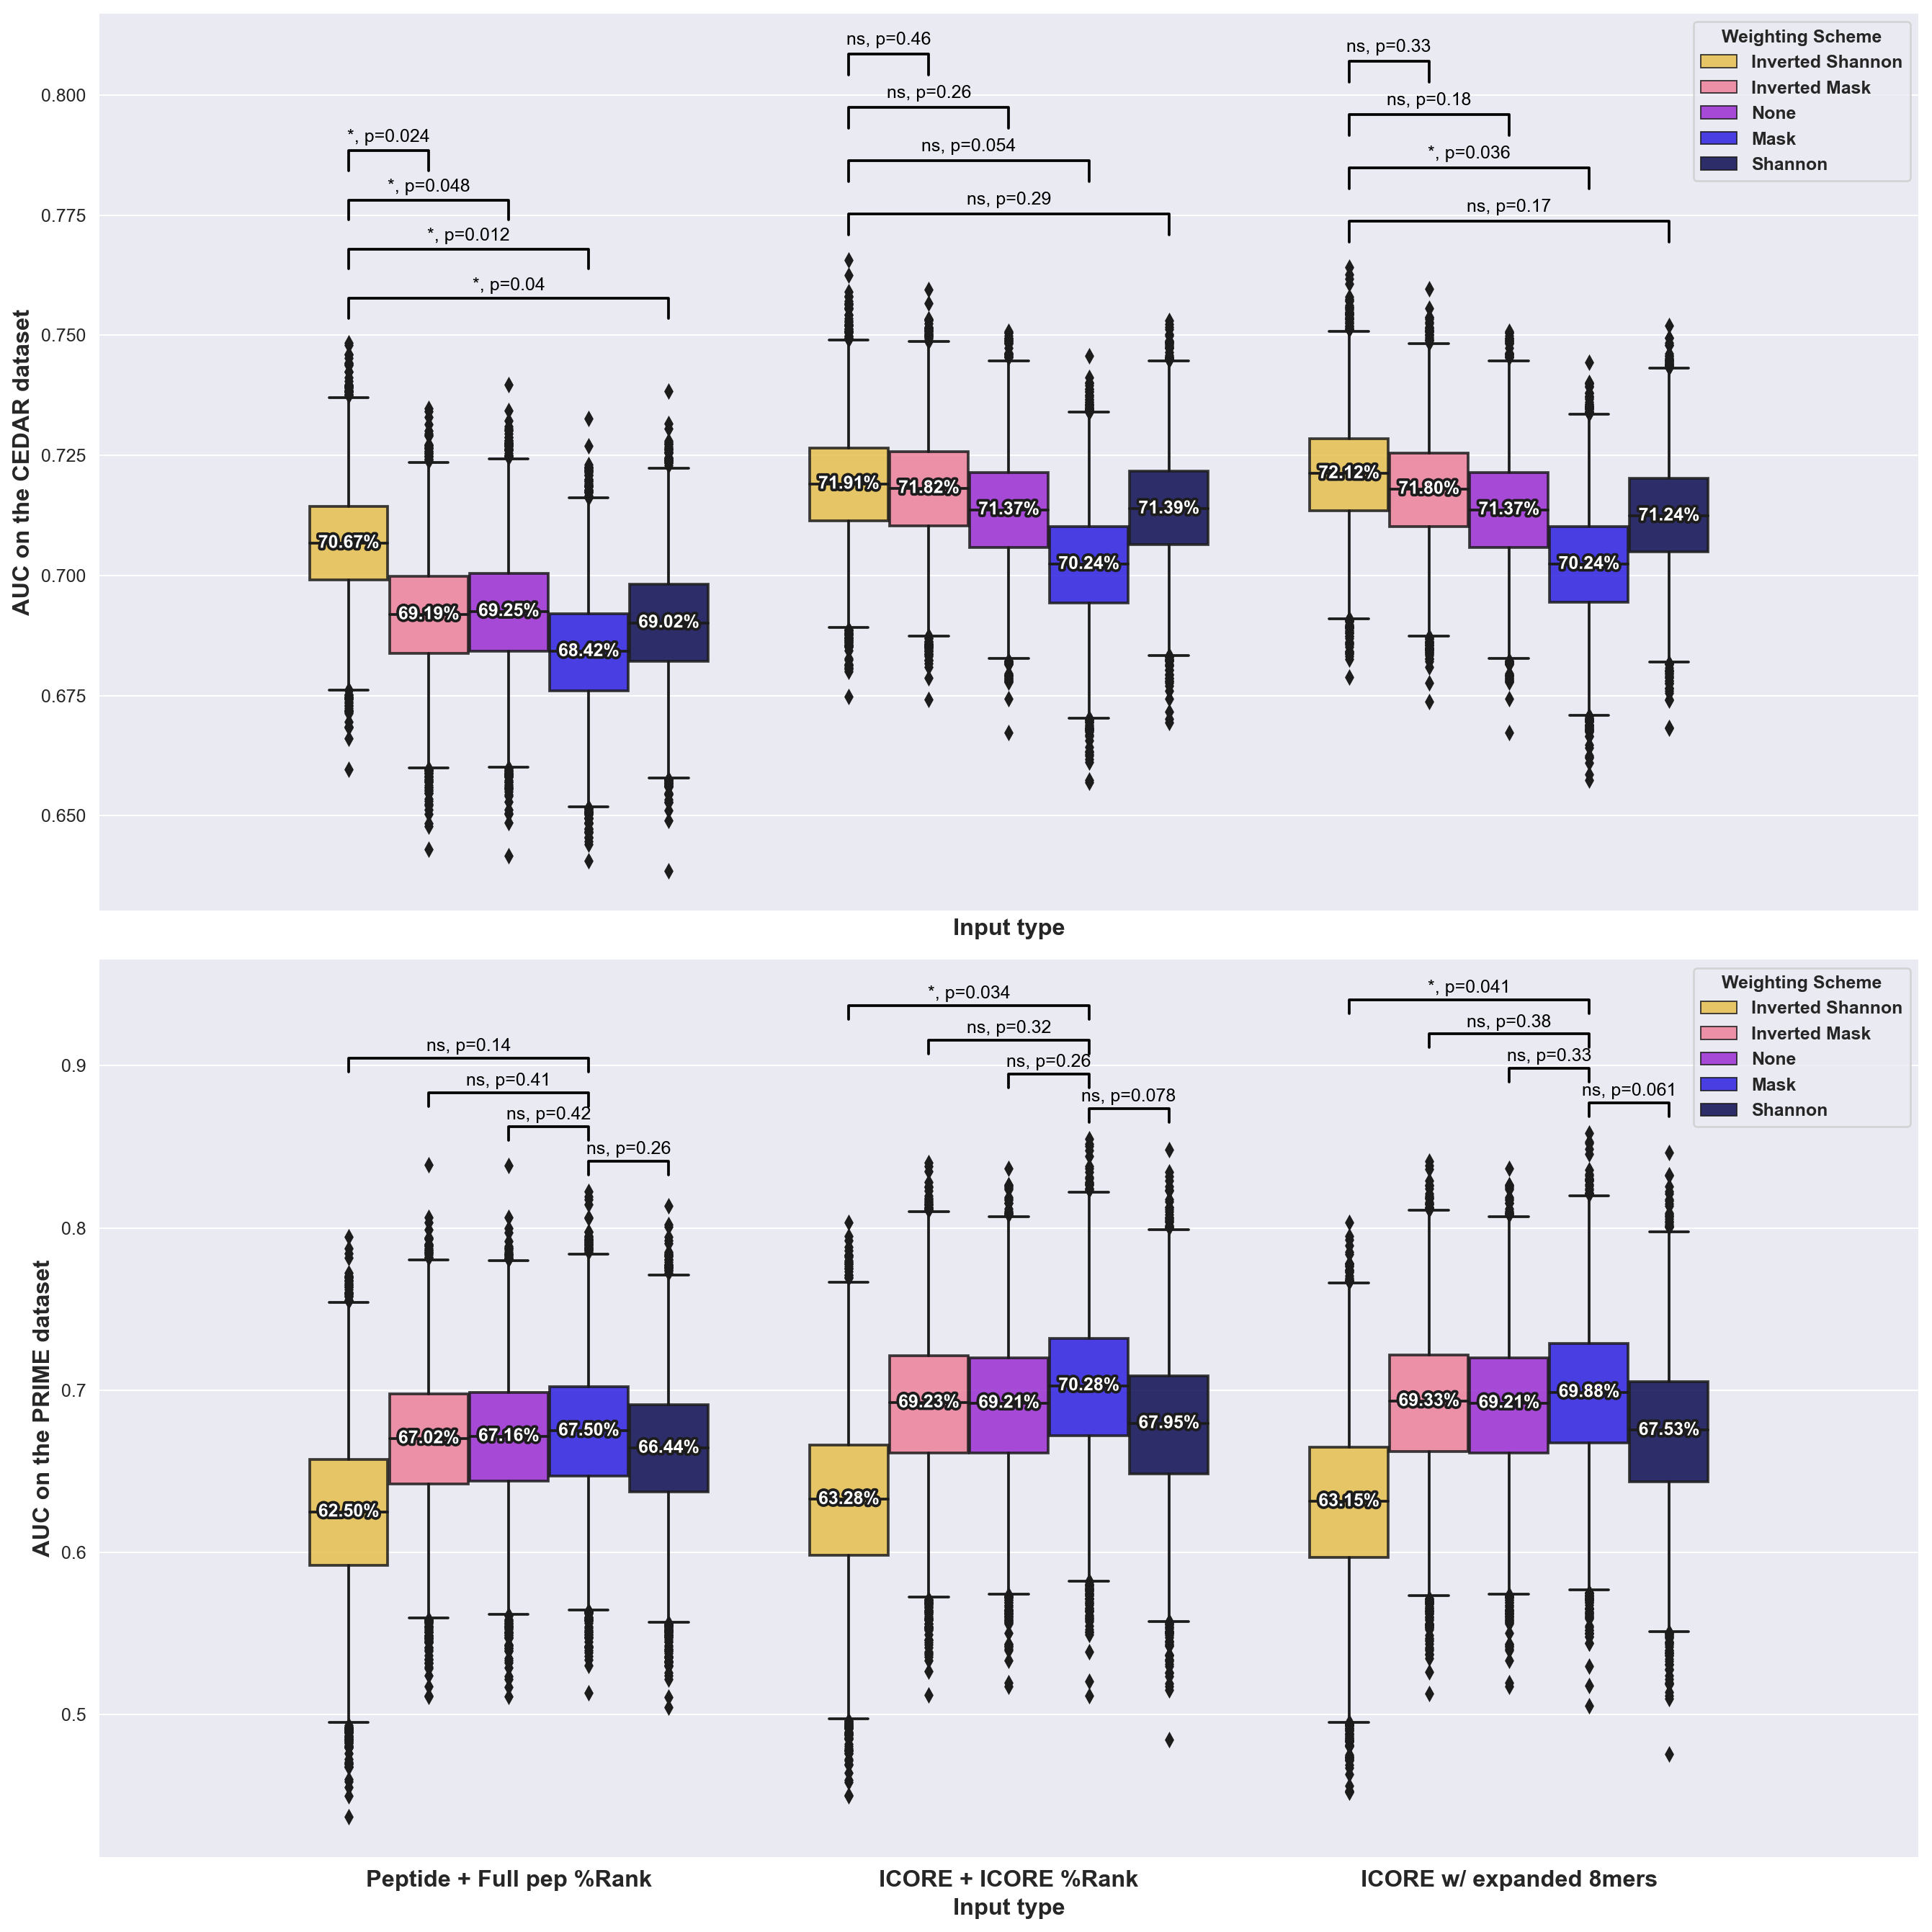

In [446]:
# Remake plot but with both evalsets :

# Remake fig4 for PRIME

# Redo the figure here for prime only as requested
f, axis = plt.subplots(2,1, figsize=(15,15), sharex=True)
weight_order = ['Inverted Shannon', 'Inverted Mask', 'None', 'Mask', 'Shannon']
weight_color_order = {k:v for k,v in zip(weight_order, get_palette('gnuplot2_r', n_colors=len(weight_order)))}
# for type_, axis in zip(cedar_total_df['type'].unique(), a.ravel()):

def get_input(row):
    if row['input_type']=='Peptide':return 'Peptide + Full pep %Rank'
    if row['input_type']=='icore_mut':return 'ICORE + ICORE %Rank'
    if row['input_type']=='expanded_input':return 'ICORE w/ expanded 8mers'

for evalset, axis in zip(['CEDAR', 'PRIME'], axis.ravel()): 

    tmp = input_df.query('evalset==@evalset')
    tmp['type']=tmp.apply(get_input,axis=1)
    sns.boxplot(data= tmp, x='type', hue = 'weight', y = 'auc',
                hue_order = weight_order, palette = weight_color_order, ax=axis)
    add_median_labels(axis, '.2%')

    # axis.set_title(f'Input: {type_}', fontweight='semibold', fontsize=13)
    axis.set_xticklabels(axis.get_xticklabels(), fontweight='semibold', fontsize=13)
    axis.set_ylabel(f'AUC on the {evalset} dataset', fontweight='semibold', fontsize=13)
    plt.setp(axis.patches, alpha=0.85)
    to_compare = 'Mask' if evalset=="PRIME" else "Inverted Shannon"
    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 0
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index(to_compare)]
    if evalset=="CEDAR" :
        h, h0 = 0.0051, 0.005125 
    else: h,h0= 0.0105, 0.01055
    aucs_mask = tmp.query('evalset==@evalset and type.str.contains("Peptide") and weight==@to_compare')

    for i, comp in enumerate(reversed(list(filter(lambda x: x!=to_compare, weight_order)))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("Peptide") and weight==@comp')
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp, 'auc')
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0

    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 1
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index(to_compare)]
    if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055
    aucs_mask = tmp.query('evalset==@evalset and type.str.contains("ICORE") and not type.str.contains("exp") and weight==@to_compare')
    for comp in reversed(list(filter(lambda x: x!=to_compare, weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("ICORE") and not type.str.contains("exp") and weight==@comp')
        print(pval, sig)
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0


    dx = .16 # Because boxwidth = 0.8 by default, and we have 5 boxes -> .8/5 = .16
    x0 = 2
    xs = [x0-2*dx, x0-dx, x0, x0+dx, x0+2*dx]
    x1 = xs[weight_order.index(to_compare)]
    if evalset=="CEDAR" :
        h, h0 = 0.005125, 0.00555 
    else: h,h0= 0.0105, 0.01055
    aucs_mask = tmp.query('evalset==@evalset and type.str.contains("exp") and weight==@to_compare')
    for comp in reversed(list(filter(lambda x: x!=to_compare, weight_order))):
        x2 = xs[weight_order.index(comp)]
        aucs_comp = tmp.query('evalset==@evalset and type.str.contains("exp") and weight==@comp')
        print(pval, sig)
        pval, sig = get_pval_wrapper(aucs_mask, aucs_comp)
        plot_pval(axis, pval, sig ,x1, x2, y=max(aucs_mask.auc.values)+h,h=h0, color='k')
        # x1+=dx
        h+=2*h0

    # axis.set_ylim([.5, .925])
    axis.legend(prop={'weight':'semibold'}, title='Weighting Scheme', title_fontproperties={'weight':'semibold'})
    # a.set_xlabel('')
    axis.set_xlabel('Input type', fontweight='semibold', fontsize=13)
f.tight_layout()
f.savefig('../../../writing/230131_cedar_paper_1/figures/230428_BOTHevalsets_weights_comparison_newpal_pvals.png',
          bbox_inches='tight', dpi=200)

# Figure 5 : Redo Feature analysis using expanded 8mers icore + Expression

In [108]:
from src.bootstrap import bootstrap_eval, get_pval_wrapper, plot_pval

fn_cedar = 'CEDAR_preds_cedar_onehot_None_expanded_input_'
fn_prime = 'PRIME_preds_cedar_onehot_None_expanded_input_'

feature_sets = ['only_rank', 'aliphatic_index-boman-hydrophobicity-isoelectric_point',
                'icore_dissimilarity_score-icore_mut_score-icore_blsm_mut_score'.replace('icore_',''), 
                'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']

feature_map = {'only_rank':'Base Model', 'aliphatic_index-boman-hydrophobicity-isoelectric_point':'PC props',
               'icore_dissimilarity_score-icore_mut_score-icore_blsm_mut_score'.replace('icore_',''):'Similarity+BLSM+Mut Scores',
               'ratio_rank': 'Scaled Agretopicity', 'EL_rank_wt_aligned':'WT %Rank', 'foreignness_score':'Foreigness Score', 'Total_Gene_TPM':'Gene Expression'}


In [111]:
 'icore_dissimilarity_score-icore_mut_score-icore_blsm_mut_score'.replace('icore_','')

'dissimilarity_score-mut_score-blsm_mut_score'

In [122]:
import itertools
cols_ = ['icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point',
             'icore_dissimilarity_score',
             'icore_blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']
mcs=[]
for L in range(0, len(cols_) + 1):
    for mc in itertools.combinations(cols_, L):
        mcs.append(list(mc))
        
cols2_ = ['icore_aliphatic_index', 'icore_boman', 'icore_hydrophobicity', 'icore_isoelectric_point',
             'icore_dissimilarity_score', 'icore_mut_score',
             'icore_blsm_mut_score', 'ratio_rank', 'EL_rank_wt_aligned', 'foreignness_score', 'Total_Gene_TPM']
mcs2=[]
for L in range(0, len(cols2_) + 1):
    for mc in itertools.combinations(cols2_, L):
        mcs2.append(list(mc))
mcs = [x for x in mcs2 if x not in mcs]
len(mcs)

1024

In [120]:
mcs = [x for x in mcs if x not in mcs2]
len(mcs)

1024

In [113]:
ls ../output/230427_FINAL_ANALYSIS_ALL/raw | grep dissimilarity_score-mut_score-blsm_mut_score

In [114]:
ls ../output/230427_FINAL_ANALYSIS_ALL/raw | grep mut_score | grep -v blsm

In [109]:

barplot_df = []
for x in feature_sets:
    filename_cedar = f'{DIR}raw/{fn_cedar}{x}.csv'
    filename_prime = f'{DIR}raw/{fn_prime}{x}.csv'
  
    tmp = pd.read_csv(filename_cedar)
    tmp['Feature'] = feature_map[x]
    tmp['evalset']= 'CEDAR'
    barplot_df.append(tmp)
    tmp = pd.read_csv(filename_prime)
    
    tmp['Feature'] = feature_map[x]
    tmp['evalset']= 'PRIME'
    barplot_df.append(tmp)
barplot_df=pd.concat(barplot_df)

FileNotFoundError: [Errno 2] No such file or directory: '../output/230427_FINAL_ANALYSIS_ALL/raw/CEDAR_preds_cedar_onehot_None_expanded_input_dissimilarity_score-mut_score-blsm_mut_score.csv'